In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn

In [2]:
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=10, tags='PSI0')

# initial layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=0)
    
# 8 rounds of entangling gates
for r in range(1, 9):
    
    # even pairs
    for i in range(0, 10, 2):
        circ.apply_gate('CNOT', i, i + 1, gate_round=r)

    # Y-rotations    
    for i in range(10):
        circ.apply_gate('RY', 1.234, i, gate_round=r)
        
    # odd pairs
    for i in range(1, 9, 2):
        circ.apply_gate('CZ', i, i + 1, gate_round=r)
    
# final layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=r + 1)
    
circ

<Circuit(n=10, n_gates=172, gate_opts={'contract': 'split-gate', 'propagate_tags': 'register'})>

The tensor network representing the state is stored in the 
``.psi`` attribute, which we can then visualize:

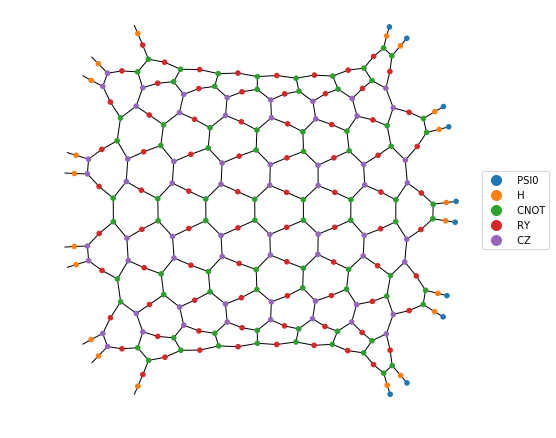

In [3]:
circ.psi.graph(color=['PSI0', 'H', 'CNOT', 'RY', 'CZ'])

Note by default the CNOT gates have
been split into two parts acting on each site seperately. 
We can also graph the default (``propagate_tags='register'``) method for 
adding site tags to the applied operators:

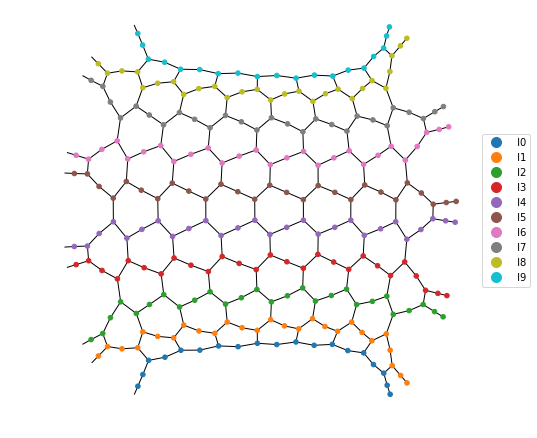

In [4]:
circ.psi.graph(color=[f'I{i}' for i in range(10)])

Or since we supplied ``gate_round`` as an keyword (which is optional), the tensors
are also tagged ini that way:

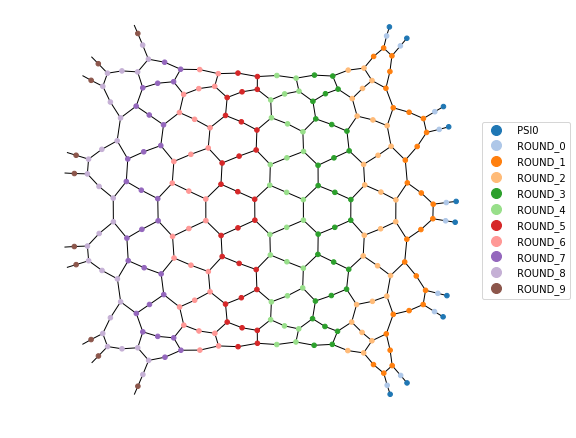

In [5]:
circ.psi.graph(color=['PSI0'] + [f'ROUND_{i}' for i in range(10)])

All of these are helpful when addressing only certain tensors:

In [6]:
# select the subnetwork of tensors with *all* following tags
circ.psi.select(['CNOT', 'I3', 'ROUND_3'], which='all')

<TensorNetwork(tensors=1, structure='I{}', nsites=10)>

The full list of implemented gates is here:

In [7]:
qtn.circuit.APPLY_GATES.keys()

dict_keys(['RZ', 'RY', 'RX', 'H', 'X', 'Y', 'Z', 'S', 'T', 'X_1_2', 'Y_1_2', 'CX', 'CY', 'CZ', 'CNOT'])

To check the gates were entangling, we can contract the whole network into a dense 
representation of the state:

In [8]:
psi_dense = circ.psi ^ all

# check the half chain entanglement
psi_dense.entropy(left_inds=['k0', 'k1', 'k2', 'k3', 'k4'])

2.6607377436569184

QASM Format and Advanced Manipulation
-------------------------------------

In [9]:
circ = qtn.Circuit.from_qasm_file('inst_7x7_31_0.txt', tags='PSI_i')

We'll compute the output amplitude of a random bitstring:

In [10]:
import random
random.seed(42)

bitstring = "".join(random.choice('01') for _ in range(49))
print(bitstring)

# the squeeze removes all size 1 bonds
psi_sample = qtn.MPS_computational_state(bitstring, tags='PSI_f').squeeze()

0010000010000000101100111001001011101010110000100


The amplitude tensor network is then given by:

In [11]:
c_tn = circ.psi & psi_sample
c_tn

<TensorNetwork(tensors=1402, structure='I{}', nsites=49)>

(Note if we instead left some indices open we could compute *slices* of amplitudes.)

We can now view the same three tagging schemes as earlier to visualize the network with:

In [12]:
gate_tags = ['PSI_i', 'H', 'CZ', 'T', 'X_1/2', 'Y_1/2', 'PSI_f']
site_tags = [c_tn.site_tag(i) for i in range(c_tn.nsites)]
round_tags = ['PSI_i'] + ["ROUND_{}".format(i) for i in range(31)]

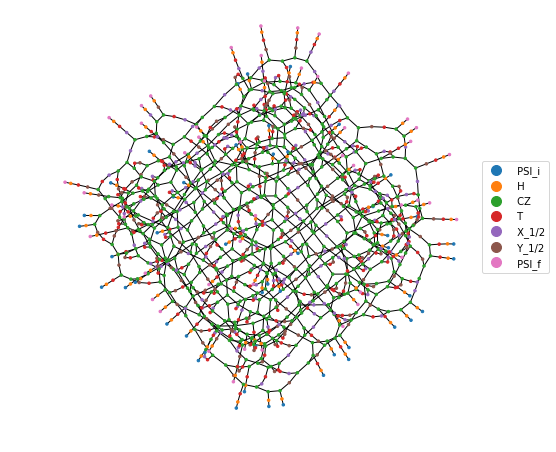

In [13]:
c_tn.graph(color=gate_tags)  # could be slow

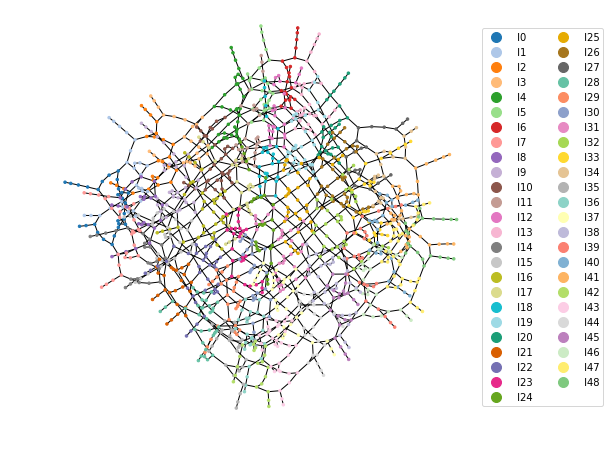

In [14]:
c_tn.graph(color=site_tags)  # could be slow

Clearly this is a complex network (1363 tensors) which it will be difficult to
find a contraction scheme for! One thing we might try is contracting all the 
rank-1 and rank-2 tensors. Doing this never increases the complexity and it
is in this sense that single qubit operations are 'free'. This can be
done with the ``.rank_simplify`` method:

In [15]:
c_tn_derank = c_tn.rank_simplify()
c_tn_derank

<TensorNetwork(tensors=534, structure='I{}', nsites=49)>

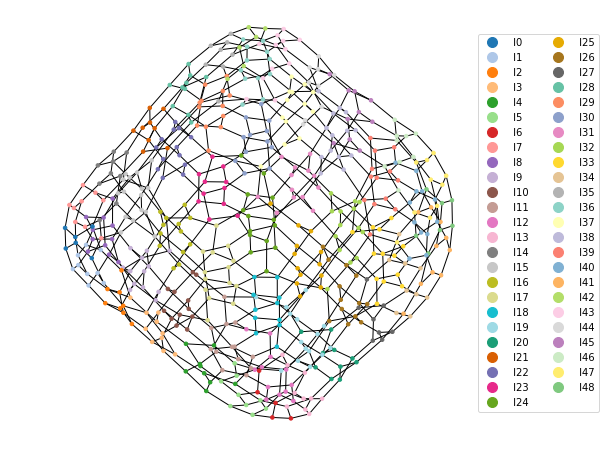

In [16]:
c_tn_derank.graph(color=site_tags)

Every tensor is now rank-3 or more. We can check $\log_2$ of the size of the largest
tensor produced in the contraction by calling:

In [17]:
c_tn_derank.contraction_complexity(optimize='random-greedy')

47.0

(Note that for this particular contraction the ``'random-greedy'`` approach is quite un-optimal, and one could use more advanced methods).

However this corresponds to far too much memory to naively contract so instead we will give the contraction some manual help,
following the rough ideas set out in https://arxiv.org/abs/1811.09599. This involves several steps:

1. Contract vertical slices for each site, yielding a simple flat network
2. 'Cutting' some bonds of the network to trade memory for time

We'll also initially take of copy of the network in single precision:

In [18]:
c_tn_flat = c_tn.astype('complex64')

# inplace contract every tensor tagged with each site tag
for i in range(c_tn.nsites):
    c_tn_flat ^= i
    
# inplace fuse multi-bonds between tensors
c_tn_flat.squeeze_(fuse=True)

# compress every bond to about 'complex64' precision
c_tn_flat.compress_all(cutoff_mode='rel', cutoff=1e-6)

We should now have a 'flat' tensor network of 49 tensors joined in a grid:

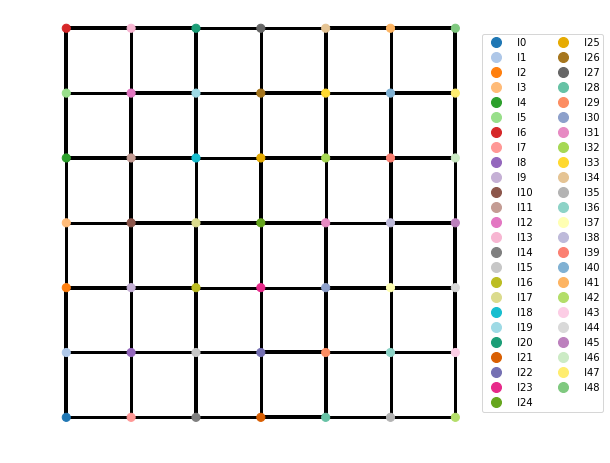

In [19]:
# we can now easily specify grid positions as well
fix = {
    c_tn_flat.site_tag(i): (i // 7, i % 7) 
    for i in range(c_tn_flat.nsites)
}

c_tn_flat.graph(site_tags, fix=fix)

Note that the new bonds are larger (and variable) but the sizes of the tensors is still manageable:

In [20]:
{qu.log2(tensor.size) for tensor in c_tn_flat}

{6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0}

And we have reduced the contraction complexity as well:

In [21]:
c_tn_flat.contraction_complexity(optimize='random-greedy')

27.0

In [22]:
# get bonds between 14-21 and 45-46
bnds = (
    qtn.bonds(c_tn_flat[14], c_tn_flat[21]) |
    qtn.bonds(c_tn_flat[45], c_tn_flat[46]) 
)
bnds

{'_2b36ef00002Eb', '_2b36ef000047c'}

We can view what it would look like to cut these bonds by 'selecting' values
for them, here 0:

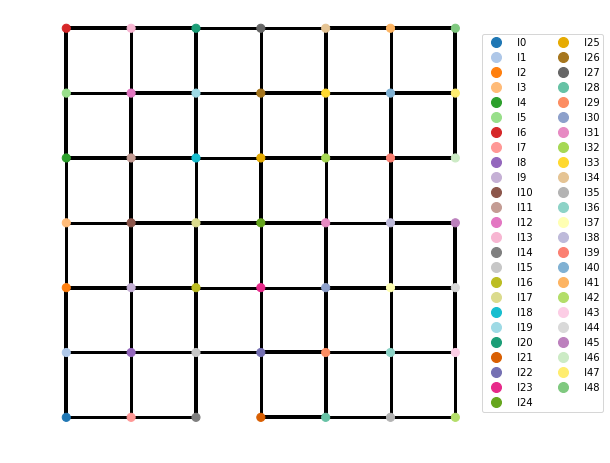

In [23]:
selector = {ix: 0 for ix in bnds}
c_tn_cut = c_tn_flat.isel(selector)

c_tn_cut.graph(color=site_tags, fix=fix)

The product of the sizes of the bonds is the number of tensor networks we will need to sum over:

In [24]:
d_cut = qu.prod(c_tn_flat.ind_size(ix) for ix in bnds)
d_cut

64

And we can check this 'cut' network has better contraction complexity:

In [25]:
c_tn_cut.contraction_complexity(optimize='random-greedy')

21.0

In [26]:
gen_cuts = c_tn_flat.cut_iter(*bnds)

# use tqdm to show progress / time (can comment this out)
from tqdm import tqdm
gen_cuts = tqdm(gen_cuts, total=d_cut)

# sum over each value the bond can take
c = sum([
    c_tn_cut.contract(all, optimize='random-greedy')
    for c_tn_cut in gen_cuts
])

100%|██████████| 64/64 [00:48<00:00,  1.18it/s]


In [27]:
c

(-5.526552548928976e-10-2.40785797828158e-08j)

In [28]:
from joblib.externals import loky

# make sure we single-thread BLAS on each process
def initializer():
    import os
    os.environ['OMP_NUM_THREADS'] = '1'
    
pool = loky.get_reusable_executor(initializer=initializer)

In [29]:
%%time

c = sum(pool.map(
    lambda c_tn_cut: c_tn_cut.contract(all, optimize='random-greedy'), 
    c_tn_flat.cut_iter(*bnds)
))

CPU times: user 1.31 s, sys: 89.9 ms, total: 1.4 s
Wall time: 16 s


In [30]:
c

(-5.526036225833586e-10-2.4078380754521955e-08j)

Which as expected matches (to single precision) the non-parallel version, and in fact is faster.

In [31]:
import dask.array as da
import cupy as cp

# copy the *uncut* network to modify each tensor
dc_tn_flat = c_tn_flat.copy()

for t in dc_tn_flat:
    # get the current tensor data
    data = t.data
    
    # convert data to GPU
    data = cp.asarray(t.data)
    
    # convert to dask array - only chunk along 'cut' bonds
    chunks = [1 if ix in bnds else None for ix in t.inds]
    data = da.from_array(data, chunks, asarray=False)
    
    # modify the tensor's data inplace
    t.modify(data=data)

We now have a tensor network of tensors backed by ``dask`` arrays, each of which
is itself backed by possibly many ``cupy`` arrays.

To perform the full contraction however, we just need to specify
``'dask'`` as the backend to ``opt_einsum``:

In [32]:
c_graph = dc_tn_flat.contract(all, optimize='random-greedy', backend='dask')

You will notice this was essentially instant- so far ``c`` this is just 
a lazily represented computation graph with unknown value:

In [33]:
c_graph

dask.array<sum-aggregate, shape=(), dtype=complex64, chunksize=()>

In this way, ``dask`` abstracts the computational graph from the method
used to compute it, meaning we can choose to actually perform 
the calcuation in a number of ways (for example on a 
[distributed server](http://distributed.dask.org/en/latest/)). Here
we'll just use the simplest, in process, scheduler:

In [34]:
%%time
c = c_graph.compute(scheduler='sync')

CPU times: user 1.39 s, sys: 400 ms, total: 1.79 s
Wall time: 1.79 s


In [35]:
c

array(-5.5275545e-10-2.4078451e-08j, dtype=complex64)

So about 10x faster than the parallel contract!